<a href="https://colab.research.google.com/github/fendy07/chatbot-AI/blob/master/DL_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chatbot With Neural Network**

<b>Chatbot</b> merupakan bagian dari Natural Language Processing yang digunakan untuk percakapan dengan pengguna melalui teks dan ucapan. Pada praktik hari ini kita akan membuat sebuah chat otomatis atau chatbot tentang program Kampus Merdeka dari Kementerian Pendidikan Kebudayaan Riset dan Teknologi (KEMENDIKBUDRISTEK). 

Dalam tahapan Chatbot ini ada tahapan yang harus kita perhatikan yaitu,

1. Import Library
2. Load Dataset
3. Preprocessing Data
4. Input Length, Output Length and Vocabulary
5. Neural Network Model
6. Model Analysis
7. Testing
8. Save Model

Dalam praktik ini, kita akan membuat chatbot tentang program Kampus Merdeka!

Sumber code: [Medium - Going Merry With Tensorflow 2.0](https://medium.com/analytics-vidhya/chatbot-with-tensorflow-2-0-going-merry-2f79284a6104)

# **Load Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Install Library Google Text To Speech** 

In [2]:
!pip -q install gtts

In [10]:
!apt install -q libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg

Reading package lists...
Building dependency tree...
Reading state information...
libportaudio2 is already the newest version (19.6.0-1).
libportaudiocpp0 is already the newest version (19.6.0-1).
portaudio19-dev is already the newest version (19.6.0-1).
libasound2-dev is already the newest version (1.1.3-5ubuntu0.6).
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [6]:
!pip -q install pysound

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Import Library**

Tahapan pertama sebelum melakukan eksplorasi dan praproses pada data adalah memasukan library yang akan digunakan untuk menganalisa dataset dengan menggunakan metode Deep Learning seperti Neural Network dalam pengolahan teks, Chatbot dll. Library yang saya gunakan yaitu NumPy untuk komputasi matematika, Matplotlib untuk visualisasi model data, Natural Language Toolkit atau NLTK untuk pengolahan teks, Pandas untuk membaca data, serta Tensorflow untuk model pada data menggunakan algoritma LSTM.

In [11]:
# Import Libraries
import json
import nltk
import time
import random
import string
import numpy as np
import pandas as pd
from gtts import gTTS
from io import BytesIO
import tensorflow as tf
import IPython.display as ipd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPool1D

# **Load Dataset Json**

Setelah import library, tahapan selanjutnya adalah me-load dataset yang telah disediakan. Dataset yang digunakan berupa format **.json** yang sangat cocok untuk membuat model Chatbot. Data Json merupakan data yang termasuk dalam *semi structured* yang dimana data ini menampung beberapa bagian data seperti **tag**, **pattern**, **context**, dan **response**. Data yang dipakai dalam proyek ini menggunakan dataset manual yang diciptakan oleh student Kampus Merdeka Batch 2 tentang <b>Chatbot Sistem Rekomendasi Kampus Merdeka</b>. [Github](https://github.com/mahmudwhd/WebKadekBot)

In [12]:
# Importing the dataset
with open('/content/drive/MyDrive/Proyek/Natural Language Processing/Chatbot/Dataset/Dataset Kampus Merdeka.json') as content:
  data1 = json.load(content)

# Mendapatkan semua data ke dalam list
tags = []
inputs = []
responses = {}
for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])

# Konversi data json ke dataframe
data = pd.DataFrame({"patterns":inputs, "tags":tags})

In [13]:
data

,patterns,tags
0,hallo,greeting
1,hai,greeting
2,halo,greeting
3,hei,greeting
4,hi,greeting
...,...,...
70,Apa itu PMMB?,penjelasan_PMMB
71,Apa saja persyaratan IISMA?,persyaratan_IISMA
72,Bagaimana periode pelaksanaan dan cara mendaft...,periode_dan_pendaftaran_PMMB
73,Apa saja manfaat apabila mengikuti PMMB?,manfaat_PMMB


In [14]:
data.head() # Cetak data baris pertama sampai baris kelima

,patterns,tags
0,hallo,greeting
1,hai,greeting
2,halo,greeting
3,hei,greeting
4,hi,greeting


In [15]:
data.tail() # Cetak data baris ke-70 sampai baris akhir

,patterns,tags
70,Apa itu PMMB?,penjelasan_PMMB
71,Apa saja persyaratan IISMA?,persyaratan_IISMA
72,Bagaimana periode pelaksanaan dan cara mendaft...,periode_dan_pendaftaran_PMMB
73,Apa saja manfaat apabila mengikuti PMMB?,manfaat_PMMB
74,Apa saja universitas yang tergabung dalam prog...,mitra_PMMB


Data yang telah kita miliki dalam format JSON yang dapat digunakan melalui pandas dengan cara konversi. Data JSON yang saya miliki didapat dengan cara manual dengan mengambil beberapa referensi website tentang program Kampus Merdeka.

# **Preprocessing The Data**

Setelah kita meload data dan mengonversi data json menjadi dataframe. Tahapan selanjutnya adalah praproses pada dataset yang kita gunakan saat ini yaitu dengan cara:

1.   Remove Punctuations
2.   Tokenization
3.   Apply Padding
4.   Encoding the Outputs

In [16]:
# Removing Punctuations (Menghilangkan Punktuasi)
data['patterns'] = data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['patterns'] = data['patterns'].apply(lambda wrd: ''.join(wrd))
data

,patterns,tags
0,hallo,greeting
1,hai,greeting
2,halo,greeting
3,hei,greeting
4,hi,greeting
...,...,...
70,apa itu pmmb,penjelasan_PMMB
71,apa saja persyaratan iisma,persyaratan_IISMA
72,bagaimana periode pelaksanaan dan cara mendaft...,periode_dan_pendaftaran_PMMB
73,apa saja manfaat apabila mengikuti pmmb,manfaat_PMMB


In [17]:
# Tokenize the data (Tokenisasi Data)
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['patterns'])
train = tokenizer.texts_to_sequences(data['patterns'])
train

[[37],
 [38],
 [39],
 [40],
 [41],
 [42],
 [43],
 [44],
 [45],
 [46],
 [47],
 [48],
 [49],
 [50],
 [51],
 [52],
 [53],
 [31],
 [54],
 [55, 31],
 [56, 57],
 [58, 59],
 [60],
 [61, 32],
 [62],
 [63, 32],
 [33, 34],
 [64],
 [33, 34, 65],
 [1, 6, 4, 5],
 [1, 66, 4, 5],
 [1, 7, 8, 4, 5],
 [1, 2, 3, 4, 5],
 [3, 4, 5, 67],
 [3, 4, 5, 68],
 [3, 4, 5, 69],
 [18, 19],
 [20],
 [4, 21],
 [9],
 [22, 23, 5],
 [24, 25],
 [26],
 [1, 6, 18, 19],
 [1, 2, 7, 18, 19],
 [10, 11, 12, 13, 14, 15, 3, 18, 19],
 [1, 2, 16, 17, 8, 18, 19],
 [1, 2, 35, 28, 29, 30, 18, 19],
 [1, 6, 20, 27],
 [1, 2, 7, 20, 27],
 [10, 11, 12, 13, 14, 15, 3, 20, 27],
 [1, 2, 16, 17, 8, 20, 27],
 [1, 2, 35, 28, 29, 30, 20, 27],
 [1, 6, 4, 21],
 [1, 2, 7, 4, 21],
 [10, 11, 12, 13, 14, 15, 3, 4, 21],
 [1, 2, 16, 17, 8, 4, 21],
 [1, 6, 9],
 [1, 2, 7, 9],
 [10, 11, 12, 13, 14, 15, 3, 9],
 [1, 2, 16, 17, 8, 9],
 [1, 2, 36, 28, 29, 30, 3, 9],
 [1, 6, 22, 23, 5],
 [1, 2, 7, 22, 23, 5],
 [10, 11, 12, 13, 14, 15, 3, 22, 23, 5],
 [1, 2, 16, 17,

In [18]:
# Apply padding 
x_train = pad_sequences(train)

# Encoding the outputs 
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])

In [19]:
print(x_train) # Padding Sequences

[[ 0  0  0  0  0  0  0  0  0 37]
 [ 0  0  0  0  0  0  0  0  0 38]
 [ 0  0  0  0  0  0  0  0  0 39]
 [ 0  0  0  0  0  0  0  0  0 40]
 [ 0  0  0  0  0  0  0  0  0 41]
 [ 0  0  0  0  0  0  0  0  0 42]
 [ 0  0  0  0  0  0  0  0  0 43]
 [ 0  0  0  0  0  0  0  0  0 44]
 [ 0  0  0  0  0  0  0  0  0 45]
 [ 0  0  0  0  0  0  0  0  0 46]
 [ 0  0  0  0  0  0  0  0  0 47]
 [ 0  0  0  0  0  0  0  0  0 48]
 [ 0  0  0  0  0  0  0  0  0 49]
 [ 0  0  0  0  0  0  0  0  0 50]
 [ 0  0  0  0  0  0  0  0  0 51]
 [ 0  0  0  0  0  0  0  0  0 52]
 [ 0  0  0  0  0  0  0  0  0 53]
 [ 0  0  0  0  0  0  0  0  0 31]
 [ 0  0  0  0  0  0  0  0  0 54]
 [ 0  0  0  0  0  0  0  0 55 31]
 [ 0  0  0  0  0  0  0  0 56 57]
 [ 0  0  0  0  0  0  0  0 58 59]
 [ 0  0  0  0  0  0  0  0  0 60]
 [ 0  0  0  0  0  0  0  0 61 32]
 [ 0  0  0  0  0  0  0  0  0 62]
 [ 0  0  0  0  0  0  0  0 63 32]
 [ 0  0  0  0  0  0  0  0 33 34]
 [ 0  0  0  0  0  0  0  0  0 64]
 [ 0  0  0  0  0  0  0 33 34 65]
 [ 0  0  0  0  0  0  1  6  4  5]
 [ 0  0  0

In [20]:
print(y_train) #Label Encodings

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0
 36 36 36 36 36 16 37 30 35 35 35 35 35 35 35 35 35 35 35 20 34 27  8 12
 17 31 24  5 11 15 29 23  4 13 28 21  2  9 19 33 26  7 18 32 25  6 14 28
 22  3 10]


Tokenizer pada Tensorflow memberikan token unik untuk setiap kata yang berbeda. Dan juga padding dilakukan untuk mendapatkan semua data dengan panjang yang sama sehingga dapat mengirimkannya ke lapisan atau layer RNN. variabel target juga dikodekan menjadi nilai desimal.

# **Input Length, Output Length and Vocabulary**



In [21]:
# input length
input_shape = x_train.shape[1]
print(input_shape)

10


In [22]:
# define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words : ", vocabulary)

# output length
output_length = le.classes_.shape[0]
print("output length: ", output_length)

number of unique words :  69
output length:  38


**Input length** dan **output length** terlihat sangat jelas hasilnya. Mereka adalah untuk bentuk input dan bentuk output dari jaringan syaraf pada algoritma Neural Network.

**Vocabulary Size** adalah untuk lapisan penyematan untuk membuat representasi vektor unik untuk setiap kata.

# **Neural Network Model**

Jaringan syaraf yang terdiri dari lapisan embedding yang merupakan salah satu hal yang paling kuat di bidang pemrosesan bahasa alami atau NLP. output atau keluaran dari lapisan embedding adalah input dari lapisan berulang (*recurrent*) dengan LSTM gate. Kemudian, output diratakan dan lapisan Dense digunakan dengan fungsi aktivasi softmax.

Bagian utama adalah lapisan embedding yang memberikan vektor yang sesuai untuk setiap kata dalam dataset.

In [24]:
# Creating the model (Membuat Modeling)
i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1,10)(i) # Layer Embedding
x = LSTM(10, return_sequences=True)(x) # Layer Long Short Term Memory
x = Flatten()(x) # Layer Flatten
x = Dense(output_length, activation="softmax")(x) # Layer Dense
model  = Model(i,x)

# Compiling the model (Kompilasi Model)
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

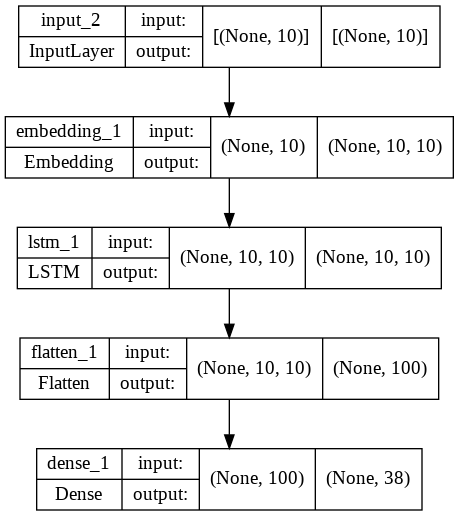

In [25]:
# Visualization Plot Architecture Model (Visualisasi Plot Arsitektur Model)
plot_model(model, to_file='/content/drive/MyDrive/Proyek/Natural Language Processing/Chatbot/model_plot.png', show_shapes=True, show_layer_names=True)

In [26]:
model.summary() # Menampilkan Parameter Model

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 10, 10)            700       
                                                                 
 lstm_1 (LSTM)               (None, 10, 10)            840       
                                                                 
 flatten_1 (Flatten)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 38)                3838      
                                                                 
Total params: 5,378
Trainable params: 5,378
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Training the model (Latih Model Data)
train = model.fit(x_train, y_train, epochs=350)

Epoch 1/350
3/3 [==============================] - 3s 10ms/step - loss: 3.6357 - accuracy: 0.0133
Epoch 2/350
3/3 [==============================] - 0s 9ms/step - loss: 3.6288 - accuracy: 0.0400
Epoch 3/350
3/3 [==============================] - 0s 10ms/step - loss: 3.6212 - accuracy: 0.0667
Epoch 4/350
3/3 [==============================] - 0s 15ms/step - loss: 3.6134 - accuracy: 0.0667
Epoch 5/350
3/3 [==============================] - 0s 9ms/step - loss: 3.6038 - accuracy: 0.0667
Epoch 6/350
3/3 [==============================] - 0s 12ms/step - loss: 3.5926 - accuracy: 0.0667
Epoch 7/350
3/3 [==============================] - 0s 10ms/step - loss: 3.5795 - accuracy: 0.0667
Epoch 8/350
3/3 [==============================] - 0s 11ms/step - loss: 3.5639 - accuracy: 0.0800
Epoch 9/350
3/3 [==============================] - 0s 10ms/step - loss: 3.5441 - accuracy: 0.1067
Epoch 10/350
3/3 [==============================] - 0s 9ms/step - loss: 3.5230 - accuracy: 0.1067
Epoch 11/350
3/3 [====

# **Model Analysis**

Setelah menjalankan model fitting. Selanjutnya adalah analisa model untuk melihat hasil akurasi dari model Neural Network tersebut.

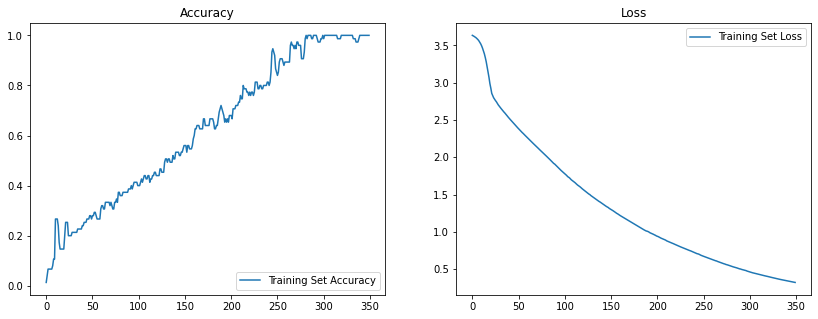

In [28]:
# Plotting model Accuracy and Loss (Visualisasi Plot Hasil Akurasi dan Loss)
# Plot Akurasi
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(train.history['accuracy'],label='Training Set Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(train.history['loss'],label='Training Set Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

# **Testing Chatbot Dan Tambahkan Suara Pada Chatbot**

Setelah mengetahui hasil dari akurasi dan loss pada model yang telah ditetapkan dengan algoritma Neural Network dan LSTM. Maka, tahapan selanjutnya adalah menguji atau testing pada chatbot yang telah dilatih sebelumnya dan melihat apakah sesuai atau tidak pada saat kita masukan teks kalimat pertanyaannya.

In [30]:
# Membuat Input Chat
while True:
  texts_p = []
  prediction_input = input('Kamu : ')
  
  # Menghapus punktuasi dan konversi ke huruf kecil
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts_p.append(prediction_input)

  # Tokenisasi dan Padding
  prediction_input = tokenizer.texts_to_sequences(texts_p)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input],input_shape)

  # Mendapatkan hasil keluaran pada model 
  output = model.predict(prediction_input)
  output = output.argmax()

  # Menemukan respon sesuai data tag dan memainkan voice bot
  response_tag = le.inverse_transform([output])[0]
  print("KadekBot : ", random.choice(responses[response_tag]))
  tts = gTTS(random.choice(responses[response_tag]), lang='id')
  tts.save('/content/drive/MyDrive/Proyek/Natural Language Processing/Chatbot/Model/KadekBot.wav')
  time.sleep(0.08)
  ipd.display(ipd.Audio('/content/drive/MyDrive/Proyek/Natural Language Processing/Chatbot/Model/KadekBot.wav', autoplay=True))
  print("="*60 + "\n")
  if response_tag == "goodbye":
    break

Kamu : Halo
KadekBot :  Helo! Ini Kadekbot. Lagi kepo tentang kampus merdeka ya?



Kamu : Kampus Merdeka itu apa?
KadekBot :  Mau tau tentang apa nih?



Kamu : Studi Independen
KadekBot :  Mau tau tentang apa nih?



Kamu : Apa saja persyaratan Studi independen?
KadekBot :  Tidak ada persyaratan khusus. Seluruh mahasiswa dari perguruan tinggi dan program studi apapun dapat mengikuti program sesuai persyaratan setiap mitra



Kamu : Apa tujuan Kampus Merdeka?
KadekBot :  Tujuan kebijakan Kampus Merdeka adalah memberikan kesempatan kepada mahasiswa untuk memilih mata kuliah yang akan mereka tempuh berdasarkan keinginan sendiri serta mendorong mahasiswa meningkatkan soft skills serta hard skills agar siap bersaing dalam dunia global.



Kamu : Terima kasih yaa
KadekBot :  Dengan senang hati:)



Kamu : Bye
KadekBot :  Bye!


# **Save The Model**

In [31]:
model.save('/content/drive/MyDrive/Proyek/Natural Language Processing/Chatbot/Model/chat_model.h5')

print('Model Successfully!')

Model Successfully!


# **Load the Model**